Learning Optimal Tic-Tac-Toe Moves via a Neural Network
-------------------------------------------------------
We will build a one-hidden layer neural network
 to predict the optimal response given a set
 of tic-tac-toe boards.

In [0]:
# Definition of X's, O's, and empty spots:
# X = 1
# O = -1
# empty = 0
# response on 1-9 grid for placement of next '1'

# For example, the 'test_board' is:
#
#   O  |  -  |  -
# -----------------
#   X  |  O  |  O
# -----------------
#   -  |  -  |  X
#
# board above = [-1, 0, 0, 1, -1, -1, 0, 0, 1]
# Optimal response would be position 6, where
# the position numbers are:
#
#   0  |  1  |  2
# -----------------
#   3  |  4  |  5
# -----------------
#   6  |  7  |  8

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [0]:
# Read in board move csv file
def get_moves_from_csv(csv_file):
  
    """
    :param csv_file: csv file location containing the boards w/ responses
    :return: moves: list of moves with index of best response
    """
    
    play_moves = []
    with open(csv_file, 'rt') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            play_moves.append(([int(x) for x in row[0:9]], int(row[9])))
    return play_moves

In [0]:
# Given a board, a response, and a transformation, get the new board+response
def get_symmetry(board, play_response, transformation):
  
    """
    :param board: list of integers 9 long:
     opposing mark = -1
     friendly mark = 1
     empty space = 0
    :param play_response: integer of where response is (0-8)
    :param transformation: one of five transformations on a board:
     'rotate180', 'rotate90', 'rotate270', 'flip_v', 'flip_h'
    :return: tuple: (new_board, new_response)
    """
    
    if transformation == 'rotate180':
        new_response = 8 - play_response
        return board[::-1], new_response
      
    elif transformation == 'rotate90':
        new_response = [6, 3, 0, 7, 4, 1, 8, 5, 2].index(play_response)
        tuple_board = list(zip(*[board[6:9], board[3:6], board[0:3]]))
        return [value for item in tuple_board for value in item], new_response
      
    elif transformation == 'rotate270':
        new_response = [2, 5, 8, 1, 4, 7, 0, 3, 6].index(play_response)
        tuple_board = list(zip(*[board[0:3], board[3:6], board[6:9]]))[::-1]
        return [value for item in tuple_board for value in item], new_response
      
    elif transformation == 'flip_v':
        new_response = [6, 7, 8, 3, 4, 5, 0, 1, 2].index(play_response)
        return board[6:9] + board[3:6] + board[0:3], new_response
      
    elif transformation == 'flip_h':  # flip_h = rotate180, then flip_v
        new_response = [2, 1, 0, 5, 4, 3, 8, 7, 6].index(play_response)
        new_board = board[::-1]
        return new_board[6:9] + new_board[3:6] + new_board[0:3], new_response
      
    else:
        raise ValueError('Method not implemented.')

In [0]:
# Get random board with optimal move
def get_rand_move(play_moves, rand_transforms=2):
  
    """
    :param play_moves: list of the boards w/responses
    :param rand_transforms: how many random transforms performed on each
    :return: (board, response), board is a list of 9 integers, response is 1 int
    """
    
    (board, play_response) = random.choice(play_moves)
    possible_transforms = ['rotate90', 'rotate180', 'rotate270', 'flip_v', 'flip_h']
    for _ in range(rand_transforms):
        random_transform = random.choice(possible_transforms)
        (board, play_response) = get_symmetry(board, play_response, random_transform)
    return board, play_response

In [0]:
# Print a board
def print_board(board):
    symbols = ['O', ' ', 'X']
    board_plus1 = [int(x) + 1 for x in board]
    board_line1 = ' {} | {} | {}'.format(symbols[board_plus1[0]],
                                         symbols[board_plus1[1]],
                                         symbols[board_plus1[2]])
    board_line2 = ' {} | {} | {}'.format(symbols[board_plus1[3]],
                                         symbols[board_plus1[4]],
                                         symbols[board_plus1[5]])
    board_line3 = ' {} | {} | {}'.format(symbols[board_plus1[6]],
                                         symbols[board_plus1[7]],
                                         symbols[board_plus1[8]])
    print(board_line1)
    print('___________')
    print(board_line2)
    print('___________')
    print(board_line3)

In [0]:
# Test board optimal response:
response = 6

# Set batch size and five different symmetries of board positions
batch_size = 50
symmetry = ['rotate180', 'rotate90', 'rotate270', 'flip_v', 'flip_h']

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

# Get list of optimal moves w/ responses
moves = get_moves_from_csv('/content/gdrive/My Drive/Practice/2019_SKT_AI Courese_Practice/Day2/Practice/03_Neural_Networks/06_tic_tac_toe_moves/base_tic_tac_toe_moves.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
moves

[([0, 0, 0, 0, -1, 0, 0, 0, 0], 0),
 ([0, -1, 0, 0, 0, 0, 0, 0, 0], 0),
 ([0, 0, 0, 0, 0, -1, 0, 0, 0], 6),
 ([-1, 0, 0, 0, 0, 0, 0, 0, 0], 4),
 ([0, 0, 0, 0, 0, 0, 1, -1, -1], 3),
 ([0, -1, 0, 0, 1, 0, 0, 0, -1], 0),
 ([0, -1, 1, 0, 0, -1, 0, 0, 0], 7),
 ([-1, 0, 0, 0, -1, 0, 0, 0, 1], 6),
 ([0, 0, 1, 0, 0, -1, -1, 0, 0], 4),
 ([0, 0, -1, 0, 0, 0, 0, -1, 1], 4),
 ([1, 0, 0, -1, 0, 0, 0, -1, 0], 2),
 ([0, 0, -1, 0, 1, 0, -1, 0, 0], 5),
 ([-1, 0, 0, 1, -1, -1, 0, 0, 1], 6),
 ([-1, 1, -1, 0, 1, 0, 0, 1, 0], 8),
 ([0, 0, 0, -1, 0, 1, 1, -1, -1], 1),
 ([-1, 1, 0, 0, 0, -1, 0, -1, 1], 3),
 ([0, -1, 1, 0, 1, -1, -1, 0, 0], 8),
 ([0, 0, -1, 1, 0, -1, 0, -1, 1], 0),
 ([1, -1, 0, 0, -1, 0, 0, 0, 0], 7),
 ([1, 0, -1, 0, -1, 0, 0, 0, 0], 6),
 ([1, 0, 0, 0, -1, 0, -1, 0, 0], 2),
 ([1, 0, 0, 0, -1, -1, 0, 0, 0], 3),
 ([1, 0, 0, 0, -1, 0, 0, 0, -1], 6),
 ([1, -1, 0, -1, -1, 0, 0, 1, 0], 5),
 ([1, -1, 0, 0, -1, 0, -1, 1, 0], 2),
 ([1, -1, -1, 0, -1, 0, 0, 1, 0], 6),
 ([1, -1, 0, 0, -1, -1, 0, 1, 0], 

In [0]:
np.shape(moves)

(31, 2)

In [0]:
# Create a train set:
train_length = 500
train_set = []
for t in range(train_length):
    train_set.append(get_rand_move(moves))

In [0]:
# To see if the network learns anything new, we will remove all instances of the board [-1, 0, 0, 1, -1, -1, 0, 0, 1],
# which the optimal response will be the index '6'.  We will test this at the end.
test_board = [-1, 0, 0, 1, -1, -1, 0, 0, 1]
train_set = [x for x in train_set if x[0] != test_board]

In [0]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape))

In [0]:
def model(X, A1, A2, bias1, bias2):
    layer1 = tf.nn.sigmoid(tf.add(tf.matmul(X, A1), bias1))
    layer2 = tf.add(tf.matmul(layer1, A2), bias2)
    
    # Note: we don't take the softmax at the end because our cost function does that for us
    return layer2

In [0]:
X = tf.placeholder(dtype=tf.float32, shape=[None, 9])
Y = tf.placeholder(dtype=tf.int32, shape=[None])


% Practice: 1st layer: 9x81, 2nd layer: 81x9
A1 = ?
bias1 = ?
A2 = ?
bias2 = ?

model_output = ?

loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=Y))
train_step = tf.train.GradientDescentOptimizer(0.025).minimize(loss)
prediction = tf.argmax(model_output, 1)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [0]:
loss_vec = []

for i in range(10000):
    rand_indices = np.random.choice(range(len(train_set)), batch_size, replace=False)
    batch_data = [train_set[i] for i in rand_indices]
    
    x_input = [x[0] for x in batch_data]
    y_target = np.array([y[1] for y in batch_data])
    
    sess.run(train_step, feed_dict={X: x_input, Y: y_target})
    
    temp_loss = sess.run(loss, feed_dict={X: x_input, Y: y_target})
    loss_vec.append(temp_loss)
    
    if i % 500 == 0:
        print('Iteration: {}, Loss: {}'.format(i, temp_loss))

Iteration: 0, Loss: 8.250235557556152
Iteration: 500, Loss: 1.9291459321975708
Iteration: 1000, Loss: 1.589677095413208
Iteration: 1500, Loss: 1.7496140003204346
Iteration: 2000, Loss: 1.369173526763916
Iteration: 2500, Loss: 1.142882227897644
Iteration: 3000, Loss: 1.2499470710754395
Iteration: 3500, Loss: 1.1746361255645752
Iteration: 4000, Loss: 0.9252790808677673
Iteration: 4500, Loss: 0.908132791519165
Iteration: 5000, Loss: 0.9803719520568848
Iteration: 5500, Loss: 0.9930598735809326
Iteration: 6000, Loss: 1.0250842571258545
Iteration: 6500, Loss: 1.110904335975647
Iteration: 7000, Loss: 0.7159649729728699
Iteration: 7500, Loss: 0.82444167137146
Iteration: 8000, Loss: 0.6455581784248352
Iteration: 8500, Loss: 0.7313253283500671
Iteration: 9000, Loss: 0.8268901705741882
Iteration: 9500, Loss: 0.7642035484313965


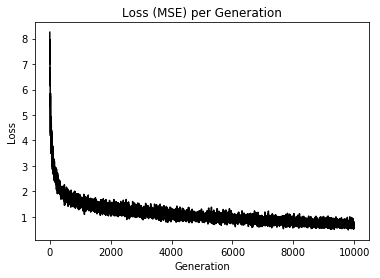

In [0]:
# Print loss
plt.plot(loss_vec, 'k-', label='Loss')
plt.title('Loss (MSE) per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [0]:
# Make Prediction:
test_boards = [test_board]
feed_dict = {X: test_boards}

logits = sess.run(model_output, feed_dict=feed_dict)
predictions = sess.run(prediction, feed_dict=feed_dict)
print(predictions)

[2]


In [0]:
# Declare function to check for win
def check(board):
    wins = [[0, 1, 2], [3, 4, 5], [6, 7, 8], [0, 3, 6], [1, 4, 7], [2, 5, 8], [0, 4, 8], [2, 4, 6]]
    for ix in range(len(wins)):
        if board[wins[ix][0]] == board[wins[ix][1]] == board[wins[ix][2]] == 1.:
            return 1
        elif board[wins[ix][0]] == board[wins[ix][1]] == board[wins[ix][2]] == -1.:
            return 1
    return 0

In [0]:
# Let's play against our model
game_tracker = [0., 0., 0., 0., 0., 0., 0., 0., 0.]
win_logical = False
num_moves = 0

while not win_logical:
    player_index = input('Input index of your move (0-8): ')
    num_moves += 1
    
    # Add player move to game
    game_tracker[int(player_index)] = 1.
    
    # Get model's move by first getting all the logits for each index
    [potential_moves] = sess.run(model_output, feed_dict={X: [game_tracker]})
    
    # Now find allowed moves (where game tracker values = 0.0)
    allowed_moves = [ix for ix, x in enumerate(game_tracker) if x == 0.0]
    
    # Find best move by taking argmax of logits if they are in allowed moves
    model_move = np.argmax([x if ix in allowed_moves else -999.0 for ix, x in enumerate(potential_moves)])
    
    # Add model move to game
    game_tracker[int(model_move)] = -1.
    print('Model has moved')
    print_board(game_tracker)
    
    # Now check for win or too many moves
    if check(game_tracker) == 1 or num_moves >= 5:
        print('Game Over!')
        win_logical = True

Input index of your move (0-8): 8
Model has moved
   |   |  
___________
   |   |  
___________
 O |   | X
Input index of your move (0-8): 5
Model has moved
   |   | O
___________
   |   | X
___________
 O |   | X
Input index of your move (0-8): 2
Model has moved
   |   | X
___________
   | O | X
___________
 O |   | X
Game Over!
